In [8]:
import numpy as np
import scipy as sp
import scipy.io
from scipy.stats import unitary_group
from datetime import datetime
import matplotlib.pyplot as plt
import qutip as qt
#from scipy.optimize import curve_fit
import os
import uuid
from itertools import repeat, chain, product, combinations
from joblib import Parallel, delayed
import glob
import time
from EMQST_lib import support_functions as sf
from EMQST_lib import emqst
from EMQST_lib.qst import QST  
from EMQST_lib.povm import POVM
from EMQST_lib import dt
from EMQST_lib import measurement_functions as mf
from EMQST_lib import visualization as vis
from EMQST_lib import overlapping_tomography as ot
from functools import reduce
from cvxopt import matrix, solvers
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading in data from .mat and .txt file

In [9]:
# Loading in the QST calibration states data.

is_math_file = False
if is_math_file:
    
    path  = "Photon_REM/photonic QREM experimental data v2/calibration states/*"
    paths = glob.glob(path)
    print(paths)
    mat_files = [glob.glob(p + "/*.mat")[0] for p in paths]

    # Load from math files
    QST_coinc_count_dic = [sp.io.loadmat(f) for f in mat_files]
    QST_keys = [list(mat.keys())[3] for mat in QST_coinc_count_dic]

    QST_coinc_counts = [mat[key] for mat, key in zip(QST_coinc_count_dic, QST_keys)]
    
    # Load reconstructed density matrices
    qst_path = "Photon_REM/photonic QREM experimental data v2/calibration states/hvvh/hvvh_rho.mat"
    calib_rho_dict = sp.io.loadmat(qst_path) 
    calib_rho = calib_rho_dict['hvvh_rho']


    # Load the QDT coincidence counts
    qdt_path = "Photon_REM/photonic QREM experimental data v2/detector tomography/detTomo_coinc.mat"
    qdt_conc_dict = sp.io.loadmat(qdt_path)
    QDT_conts = qdt_conc_dict['detTomo_coinc'].T

else: # Is .txt
    path  = "Photon_REM/photonic QREM experimental data v2/calibration states/*coinc.txt"
    paths = glob.glob(path)
    print(paths)
    QST_coinc_counts = np.array([np.loadtxt(p, skiprows=2) for p in paths])


    # Load reconstructed density matrices
    qst_path = glob.glob("Photon_REM/photonic QREM experimental data v2/calibration states/*rho.txt")
    # Read the file content
    with open(qst_path[0], 'r') as file:
        lines = file.readlines()
    print(lines)
    # Initialize a list to store the complex matrix
    complex_matrix = []

    # Parse each line
    for line in lines:
        if line.strip() and '=' not in line:  # Ignore empty lines and the definition line
            # Replace i with j to make it compatible with Python's complex numbers
            formatted_line = line.replace('i', 'j').strip()
            print(formatted_line.split())
            # Split the line by spaces to extract each complex number
            row = [complex(num) for num in formatted_line.split()]
            complex_matrix.append(row)
            
    # Convert the list to a NumPy array
    calib_rho = np.array(complex_matrix)
    #print(hvvh_rho)
    print(calib_rho)
    # Detector tomography coincidence counts
    qdt_path = "Photon_REM/photonic QREM experimental data v2/detector tomography/detTomo_coinc.txt"
    QDT_conts = np.loadtxt(qdt_path, skiprows=2)
    print(QDT_conts)

['Photon_REM/photonic QREM experimental data v2/calibration states\\hdva_coinc.txt', 'Photon_REM/photonic QREM experimental data v2/calibration states\\hrvl_coinc.txt', 'Photon_REM/photonic QREM experimental data v2/calibration states\\hvvh_coinc.txt']
['   0.0107+0.0000i  -0.0316-0.0045i  -0.0065-0.0164i  -0.0060-0.0054i\n', '  -0.0316+0.0045i   0.4460+0.0000i   0.4478+0.0584i   0.0051+0.0152i\n', '  -0.0065+0.0164i   0.4478-0.0584i   0.5366+0.0000i  -0.0058-0.0033i\n', '  -0.0060+0.0054i   0.0051-0.0152i  -0.0058+0.0033i   0.0067+0.0000i']
['0.0107+0.0000j', '-0.0316-0.0045j', '-0.0065-0.0164j', '-0.0060-0.0054j']
['-0.0316+0.0045j', '0.4460+0.0000j', '0.4478+0.0584j', '0.0051+0.0152j']
['-0.0065+0.0164j', '0.4478-0.0584j', '0.5366+0.0000j', '-0.0058-0.0033j']
['-0.0060+0.0054j', '0.0051-0.0152j', '-0.0058+0.0033j', '0.0067+0.0000j']
[[ 0.0107+0.j     -0.0316-0.0045j -0.0065-0.0164j -0.006 -0.0054j]
 [-0.0316+0.0045j  0.446 +0.j      0.4478+0.0584j  0.0051+0.0152j]
 [-0.0065+0.0164j 

### Reconstructing the calibration states from coincidences 

 op list[[13.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j 13.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j 13.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j 13.+0.j]]
 op list[[13.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j 13.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j 13.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j 13.+0.j]]
 op list[[13.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j 13.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j 13.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j 13.+0.j]]


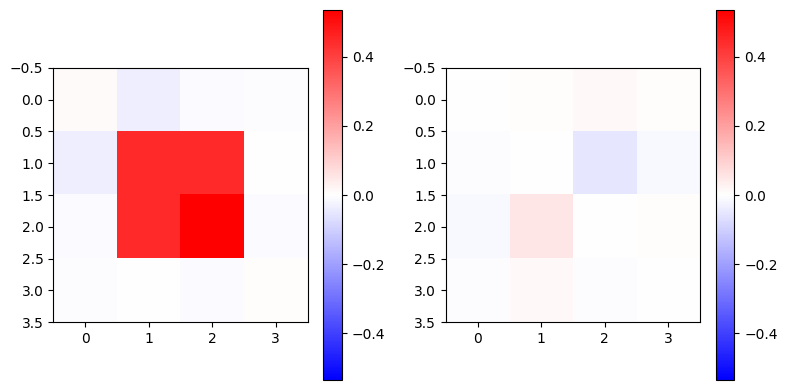

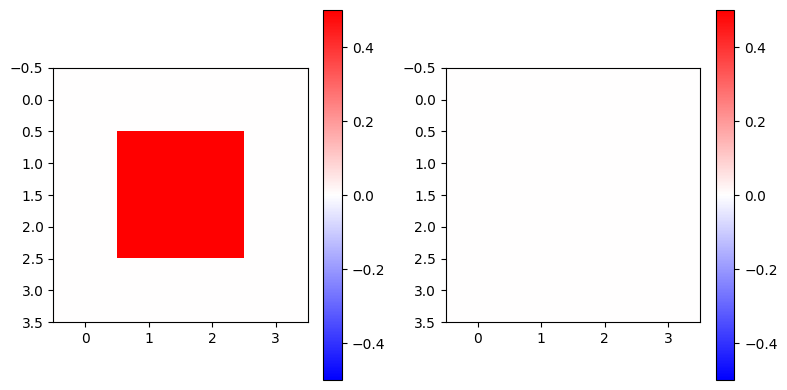

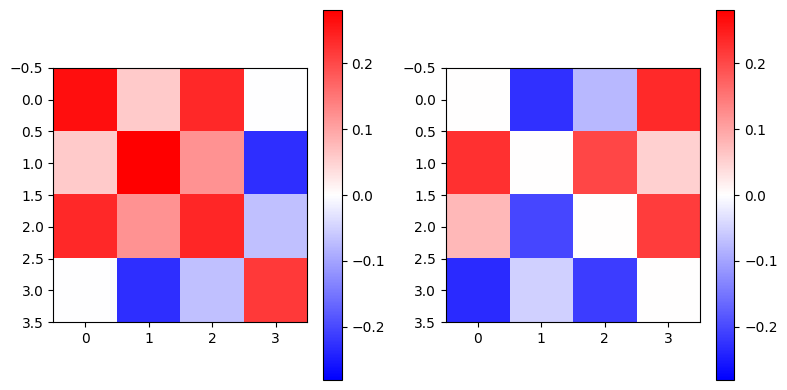

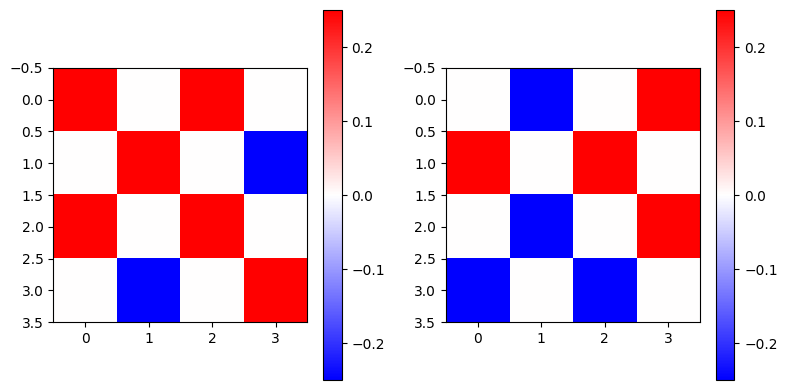

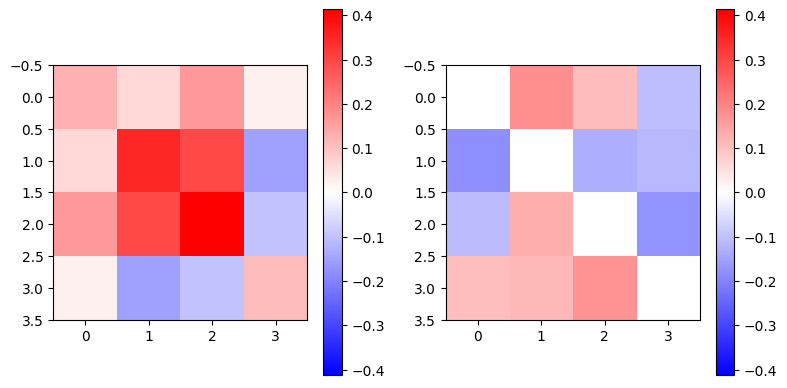

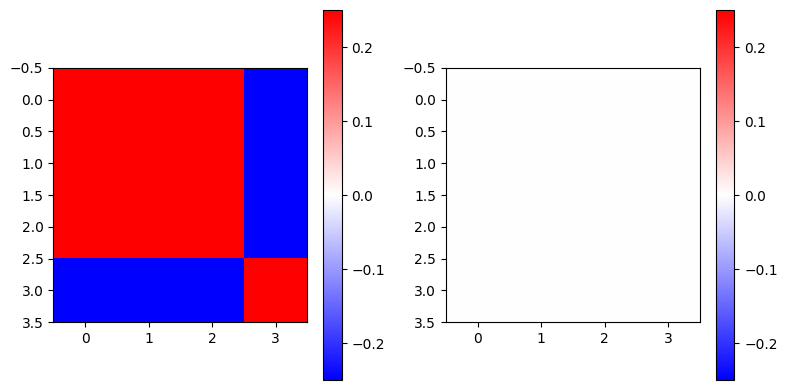

(6, 4, 4)


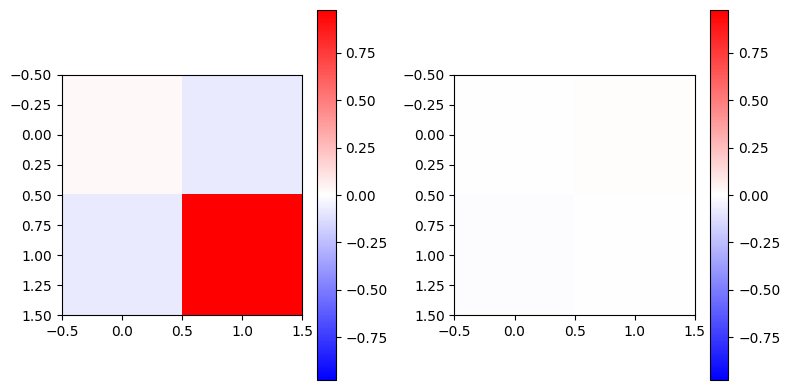

(1+6.2592723192585165e-34j)
(0.9654334743859538+1.0842021724855044e-17j)


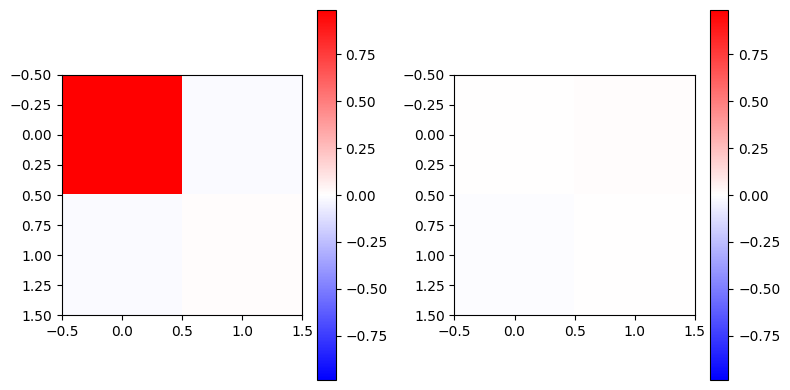

(1+2.8888949165808538e-34j)
(0.9751901461817961-2.710505431213761e-18j)


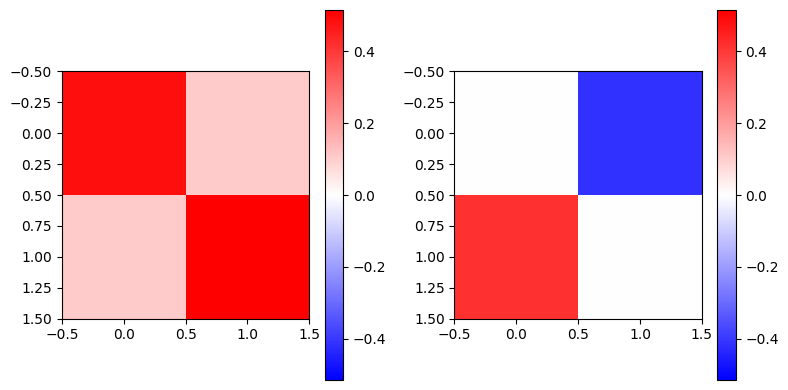

(1-6.162975822039155e-33j)
(0.8670405628100865+1.249000902703301e-16j)


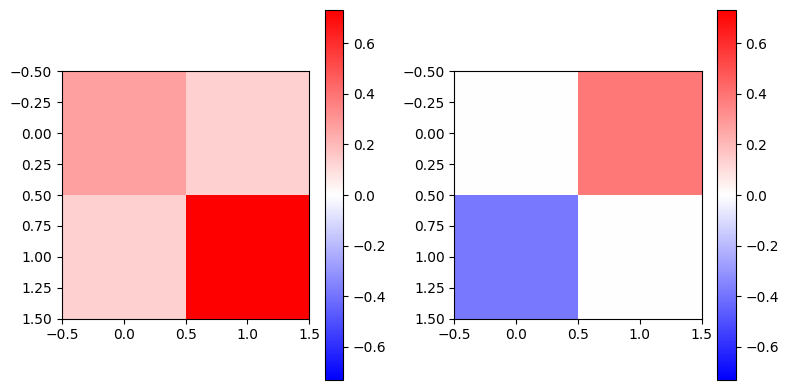

(1+1.5407439555097887e-33j)
(0.9351426279476599+6.245004513516506e-17j)


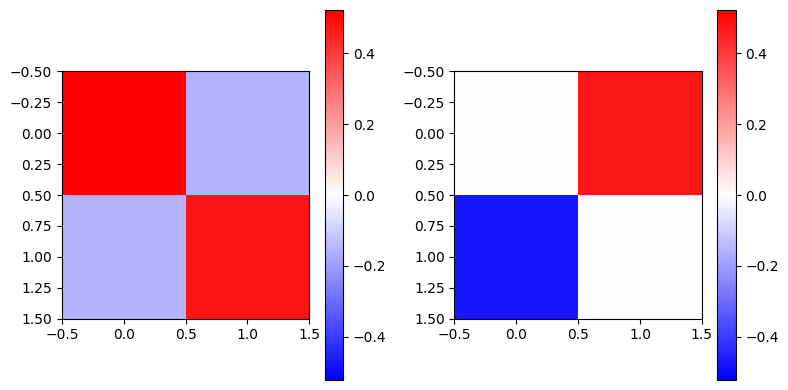

(1+6.933347799794049e-33j)
(0.9960542340234942+5.551115123125783e-17j)


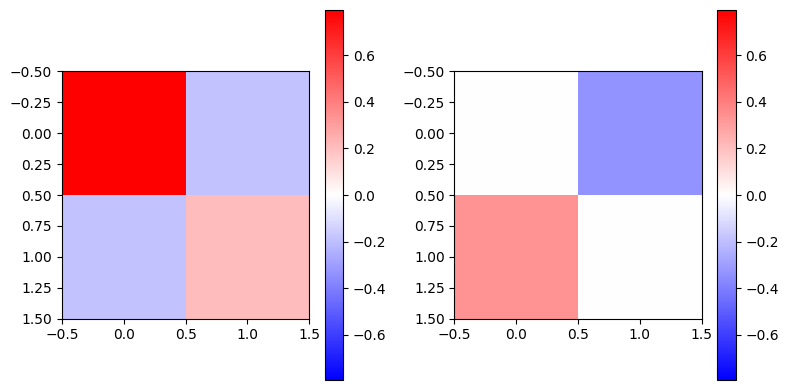

(1-3.0814879110195774e-33j)
(0.9600036445275306+2.7755575615628914e-17j)
0.07886549513098084
0.9576358799175783
0.886425264397041
0.37486273153751437


In [32]:
# Define the eigenstates
plus_x = np.array([1, 1]) / np.sqrt(2)
minus_x = np.array([1, -1]) / np.sqrt(2)

plus_y = np.array([1, 1j]) / np.sqrt(2)
minus_y = np.array([1, -1j]) / np.sqrt(2)

plus_z = np.array([1, 0])
minus_z = np.array([0, 1])

# Define density matrices
xup = np.outer(plus_x, np.conj(plus_x))
xdown = np.outer(minus_x, np.conj(minus_x))

yup = np.outer(plus_y, np.conj(plus_y))
ydown = np.outer(minus_y, np.conj(minus_y))

zup = np.outer(plus_z, np.conj(plus_z))
zdown = np.outer(minus_z, np.conj(minus_z))

# Create the ideal calibration states
# [HD + VA, HR + VL, HV + VH]
ideal_calib_states = 1/np.sqrt(2) * np.array([np.kron(plus_z,minus_z) + np.kron(minus_z,plus_z),
                                              np.kron(plus_z,plus_y) + np.kron(minus_z,minus_y),
                                              np.kron(plus_z,plus_x) + np.kron(minus_z,minus_x)
                                              ])
ideal_calib_rho = np.array([np.outer(state,np.conj(state)) for state in ideal_calib_states])
# Create operator count order 
coincidene_order_QST = ['HH', 'HV', 'VV', 'VH',
                    'RH', 'RV', 'DV', 'DH',
                    'DR', 'DD', 'RD', 'HD',
                    'VD', 'VL', 'HL', 'RL']

def photon_MLE(OP_list: np.array, index_counts: np.array ):
    '''
    Estimates state according to iterative MLE.
    :param full_operator_list: full list of POVM elemnts
    :outcome_index: list of all outcome_indices such that
            full_operator_list[index] = POVM element
    :return: dxd array of iterative MLE estimator
    '''
    dim = OP_list.shape[-1]

    iter_max = 500
    dist     = float(1)

    rho_1 = np.eye(dim)/dim
    rho_2 = np.eye(dim)/dim
    j = 0

    #unique_index, index_counts=np.unique(outcome_index,return_counts=True)
    #OP_list=full_operator_list[unique_index]
    print(f" op list{np.sum(OP_list,axis = 0)}")
    while j<iter_max and dist>1e-14:
        p      = np.einsum('ik,nki->n', rho_1, OP_list)
        R      = np.einsum('n,n,nij->ij', index_counts, 1/p, OP_list)
        update = R@rho_1@R
        rho_1  = update/np.trace(update)

        if j>=40 and j%20==0:
            dist  = sf.qubit_infidelity(rho_1, rho_2)
        rho_2 = rho_1

        j += 1

    return rho_1


def photon_label_to_operator(name_list):
    # Define the eigenstates
    plus_x = np.array([1, 1]) / np.sqrt(2)
    minus_x = np.array([1, -1]) / np.sqrt(2)

    plus_y = np.array([1, 1j]) / np.sqrt(2)
    minus_y = np.array([1, -1j]) / np.sqrt(2)

    plus_z = np.array([1, 0])
    minus_z = np.array([0, 1])

    # Define density matrices
    xup = np.outer(plus_x, np.conj(plus_x))
    xdown = np.outer(minus_x, np.conj(minus_x))

    yup = np.outer(plus_y, np.conj(plus_y))
    ydown = np.outer(minus_y, np.conj(minus_y))

    zup = np.outer(plus_z, np.conj(plus_z))
    zdown = np.outer(minus_z, np.conj(minus_z))
    # Define translation dictionary
    op_dict = {
        'H': zup,
        'V': zdown,
        'L': yup,
        'R': ydown,
        'D': xup,
        'A': xdown
    }
    if len(name_list[0]) == 1:
        return np.array([op_dict[name] for name in name_list])
    elif len(name_list[0]) == 2:
        return np.array([np.kron(op_dict[name[0]], op_dict[name[1]]) for name in name_list])
    else:  
        raise ValueError("Operator name list is not of the right format")

QST_op_order = photon_label_to_operator(coincidene_order_QST)
#print(op_order)
# Define function to create states from raw coindicence counts
def coincidence_to_states(coincidence_counts, operator_order):
    """
    Takes in experimental coincidence counts and an operator order for the counts and returns the estimated state.
    
    Steps:
    Need to turn the coincidence counts into proper probabilities and the 
    set of operators into a proper set of POVMs by adding a normalization operator. 
    """
    # Flatten standard outcome
    coincidence_counts = coincidence_counts.flatten()


    # Add additional operators for each projection, such that each operator becomes a POVM.
    # The additional operators are the identity minus the operator, making each two operator identity. 
    additional_op = np.array([np.eye(4) - op for op in operator_order])
    # Compute the total number of coincidences for each POVM on the 4 first projections. 
    n_partial = np.sum(coincidence_counts[:4]) 
    
    additional_coincidenses = n_partial - coincidence_counts

    #print(np.sum(operator_order[:4], axis = 0))
    # Include the additional operators and coincidences in the list of operators and coincidences, making them full POVMs
    new_op = np.append(operator_order,additional_op[4:],axis = 0)
    new_coincidenes = np.append(coincidence_counts, additional_coincidenses[4:])
    
    rho = photon_MLE(new_op, new_coincidenes)
    
    return rho
    
    
# reconstruct the calibration states
rho_list = [coincidence_to_states(mat, QST_op_order) for mat in QST_coinc_counts][::-1] # The flipping of the array is due to the load order of the names.
for rho, rho_ideal in zip(rho_list,ideal_calib_rho):
    vis.visualize_state(rho)
    vis.visualize_state(rho_ideal)
# vis.visualize_state(calib_rho)
    
# Trace out herald states. 
# To do this we need to first know which states was measured by the Harald.
# 1) Project ideal harald projector on the reconstructed state.  
# 2) Trace out the harald qubit, givng the calibration state. 

state_index_list = [0,0,1,2,1,2]
herald_projector_lables = ['H','V','H', 'H', 'V', 'V']
projector_list = photon_label_to_operator(herald_projector_lables)
reshaped_states = np.array(rho_list).reshape(3,2,2,2,2)
test = np.einsum('nijik -> njk', reshaped_states)
# for state in test:
#     vis.visualize_state(state)
# Apply projectors to the calibration states
projected_rho_list = np.array( [np.einsum('ij,jk,kl->il' , np.kron(proj,np.eye(2)), rho_list[rho_index], np.kron(proj,np.eye(2)) ) for rho_index, proj in zip(state_index_list, projector_list)])
print(projected_rho_list.shape)
# Renormalize the states
normalized_projected_rho_list = np.array([rho/np.trace(rho) for rho in projected_rho_list])


# Trace down
reshaped_states = normalized_projected_rho_list.reshape(6,2,2,2,2)
traced_down_calib_states = np.einsum('nijik -> njk', reshaped_states)
for state in traced_down_calib_states:
    vis.visualize_state(state)
    print(np.trace(state))
    print(np.trace(state@state))
# print(QST_coinc_counts)
# vis.visualize_state(calib_rho)
# vis.visualize_state(rho_list[0])
# print(sf.qubit_infidelity(calib_rho, rho_list[0]))
test_states =1/np.sqrt(2)*np.array([[np.kron(plus_z,plus_y) + np.kron(minus_z,minus_y)],
                        [np.kron(plus_z,minus_y) + np.kron(minus_z,plus_y)],
                        [np.kron(plus_z,plus_x) + np.kron(minus_z,minus_x)]])
test_rhos = np.array([np.outer(state,np.conj(state)) for state in test_states])
print(sf.qubit_infidelity(test_rhos[0], rho_list[1]))
print(sf.qubit_infidelity(test_rhos[1], rho_list[1]))
print(sf.qubit_infidelity(test_rhos[0], rho_list[2]))
print(sf.qubit_infidelity(test_rhos[2], rho_list[2]))

### QDT reconstruct the POVM with lense 

In [33]:
# Reconstruct the POVMs with reconstructed calibration states. 

# Reconstruct POVM for the lense

# QDT_projection_order = ['HV', 'VH', 'HR', 'HD', 'VL','VA']
# QDT_single_projection_order = ['V', 'H', 'R', 'D', 'L', 'A']
# QDT_single_op_order = photon_label_to_operator(QDT_single_projection_order)
# #print(QDT_single_op_order)
# print(QDT_conts)
# # NOTE: the load order of the calibration states are inverse of the protocol order.
# # We change the order here
# calib_rho = calib_rho[::-1]
# ideal_calib_rho = ideal_calib_rho[::-1]


    

### Simulate QDT measurements

[12457.  8190.  9444. 10015.  9225.  8963.]
[[12256   201  7159  8965]
 [ 4500 12224  8555  7204]
 [ 8096  7374 12293  6312]
 [10859  4040  2234  6887]
 [ 7562  8127  5763  9186]
 [ 5710 10241 11313  8750]]
[[  201. 12256.  5298.  3492.  7159.  8965.]
 [ 7957.   233.  3902.  5253.  8555.  7204.]
 [ 4361.  5083.   164.  6145. 12293.  6312.]
 [ 1598.  8417. 10223.  5570.  2234.  6887.]
 [ 4895.  4330.  6694.  3271.  5763.  9186.]
 [ 6747.  2216.  1144.  3707. 11313.  8750.]]
	Number of MLE iterations: 50, final distance 1.0177794718124744e-10
	Number of MLE iterations: 100, final distance 8.881784197001252e-16
	Number of MLE iterations: 950, final distance 4.5193634945484007e-10
Distance between true and expected povm [0.04376428358246573, 0.30087698458226975, 0.24627290047938266]


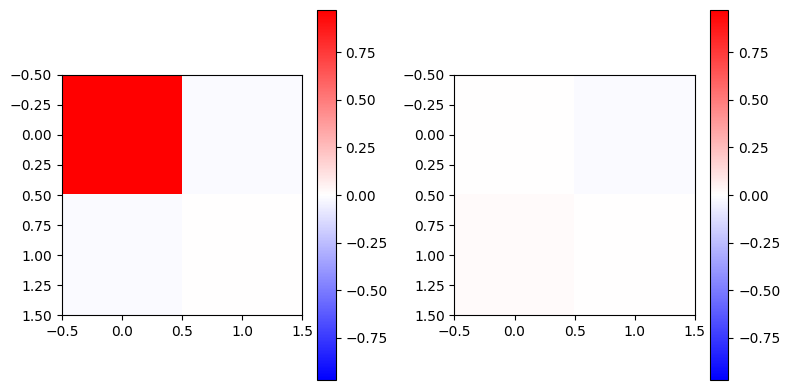

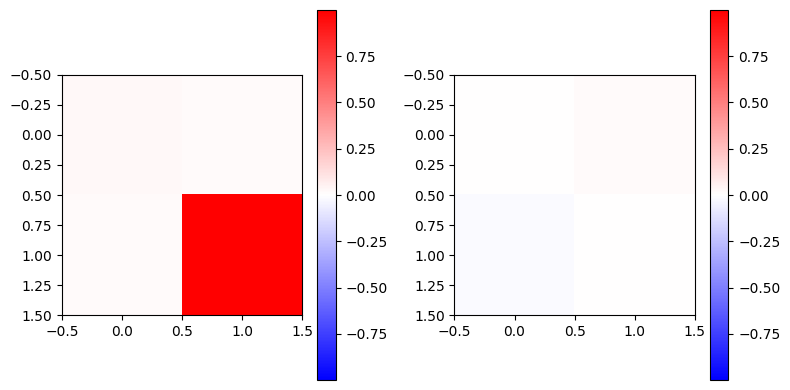

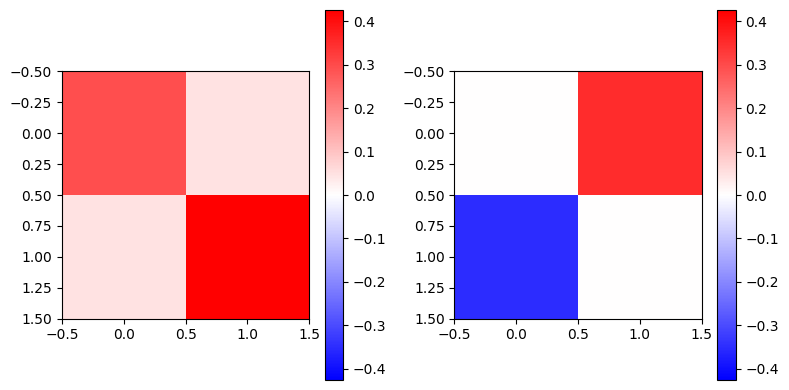

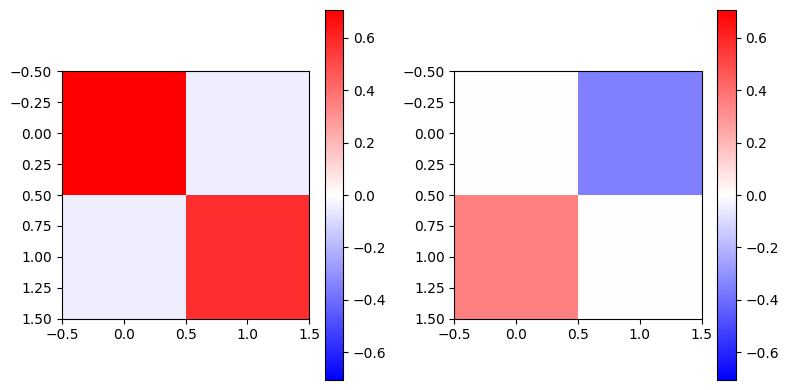

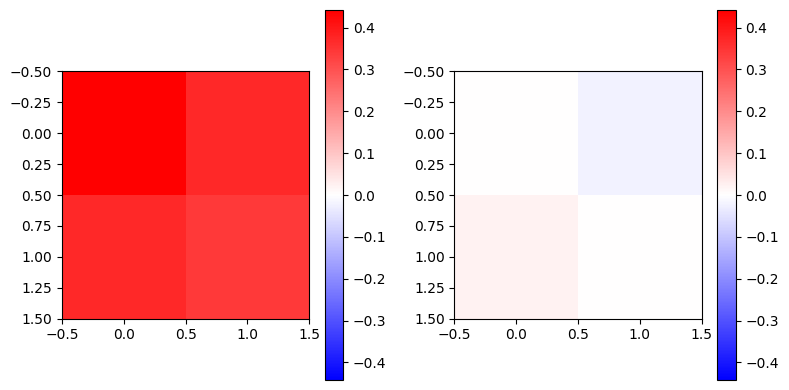

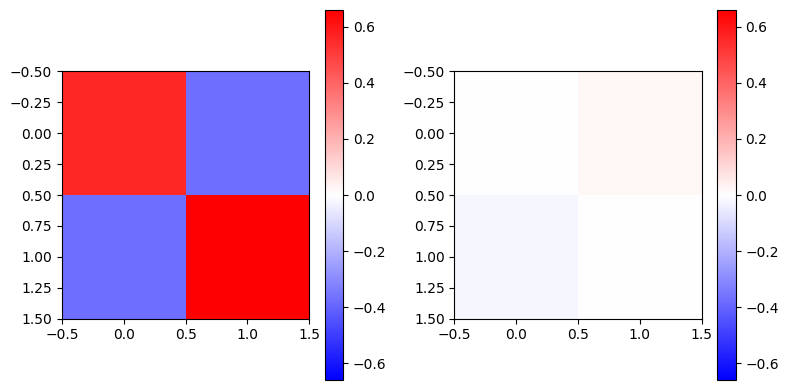

In [34]:
# def simulate_photon_coincidence_counts(N_shots, states, projectors):
    

#     prob = np.real(np.einsum('mij,nji->mn',states, projectors))
#     return N_shots*prob
# n_shots = 10**5
# state_labels = ['V','H','R', 'D', 'L','A']
# states = photon_label_to_operator(state_labels)
# states = [sf.generate_random_Bures_mixed_state(1) for _ in range(4)] 
# projector_labels = ['H','V','R','D']
# projectors = photon_label_to_operator(projector_labels)
#povm_projectors = POVM(projectors)
#povm_projectors = POVM.depolarized_POVM(povm_projectors)
# sim_coincidence = simulate_photon_coincidence_counts(n_shots, states, projectors)

def coincidence_to_POVM(QDT_coincidence, calib_states):
    """
    Takes in coincidence counts the calibration state  and returns the POVMs for [H,V] [R,L] and [D,A].
    Currently requires manual setting of order_list if the input order is not the default. 
    The default measurement order is [H,V,R,D], if other than this specify with measurement_order. 
    The QDT coincidences has shape [n_calib_states, n_measurements]
    """
    # if measurement_order is None:
    #    measurement_order = ['H', 'V', 'R', 'D']
    
    # Create inital guess states for QDT MLE
    inital_guess_POVM = POVM.generate_random_POVM(2, 2)
    
    # Find total shot count for each state
    n_shot_total = np.array([QDT_coincidence[i,0] + QDT_coincidence[i,1] for i in range(len(QDT_coincidence))])
    
    print(n_shot_total)
    # Create coincidences for the other measurements. 
    additional_coincidenses = np.array([n_shot_total[0] - QDT_coincidence[i] for i in range(len(QDT_coincidence))],dtype=int)
    print(additional_coincidenses)
    new_coincidenes = np.concatenate((QDT_coincidence,additional_coincidenses[:,2:]),axis = 1)
    print(new_coincidenes)
    new_coincidenes[new_coincidenes < 0] = 0
    # Create 3 sets of two outcome Paulies.
    # Order array set such that new_coincidences gives this order: [[H,V],[R,L],[D,A]] 
    order_list = np.array([[0,1], [2, 4], [3,5]])
    povm_recon = [dt.POVM_MLE(1, new_coincidenes[:,order]+1, calib_states[:], inital_guess_POVM) for order in order_list]
    return povm_recon
# print(sim_coincidence)
# print(np.array(states))
# povm_recon = coincidence_to_POVM(sim_coincidence, states)
true_op_order_list = [['H','V'], ['R','L'],[ 'D','A']]
true_POVMs = np.array([photon_label_to_operator(true_op_order) for true_op_order in true_op_order_list])
# dist = [sf.POVM_distance(povm.get_POVM(), true_povm) for povm, true_povm in zip(povm_recon,true_POVMs)]

# print(f'Distance between true and expected povm {dist}')

exp_povm = coincidence_to_POVM(QDT_conts.reshape((6,4)), traced_down_calib_states)
dist = [sf.POVM_distance(povm.get_POVM(), true_povm) for povm, true_povm in zip(exp_povm,true_POVMs)]

print(f'Distance between true and expected povm {dist}')

for i in range(len(exp_povm)):
    povm = exp_povm[i].get_POVM()
    vis.visualize_state(povm[0])
    vis.visualize_state(povm[1])
#print(exp_povm[0].get_POVM())

After having reconstructed the POVM, we want to implement it into the effective experiment.

[[ 9079. 12012.  7916. 11398.   576. 19536. 11110.  8965. 10047. 19125.
   8243.  9273.  9928.   139. 20324.  8689.]
 [ 2981.  4039.  3181.  3802.  1070.  6002.  5623.  1678.  2959.  5898.
   1406.  2847.  3534.    73.  9113.  4126.]]
{'H': array([[ 9.70673566e-01+5.09575021e-18j, -1.93774460e-02-1.87863454e-02j],
       [-1.93774460e-02+1.87863454e-02j,  7.50419307e-04+4.07634606e-20j]]), 'V': array([[0.02932643+1.18940087e-19j, 0.01937745+1.87863454e-02j],
       [0.01937745-1.87863454e-02j, 0.99924958+6.40150352e-19j]]), 'R': array([[0.29454554+1.04083409e-17j, 0.04726735+3.50870905e-01j],
       [0.04726735-3.50870905e-01j, 0.42555252+1.47451495e-17j]]), 'L': array([[ 0.70545446-2.35015474e-19j, -0.04726735-3.50870905e-01j],
       [-0.04726735+3.50870905e-01j,  0.57444748+3.80198625e-18j]]), 'D': array([[0.44214813-6.79759292e-18j, 0.37165012-2.32371366e-02j],
       [0.37165012+2.32371366e-02j, 0.34029286-4.40779332e-18j]]), 'A': array([[ 0.55785187-2.19184929e-18j, -0.37165012+2

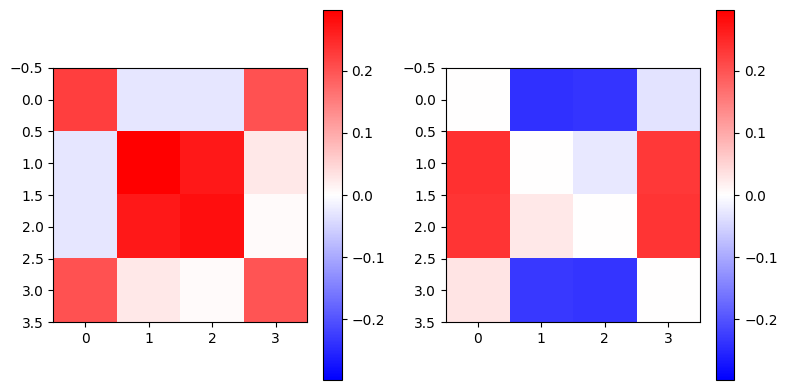

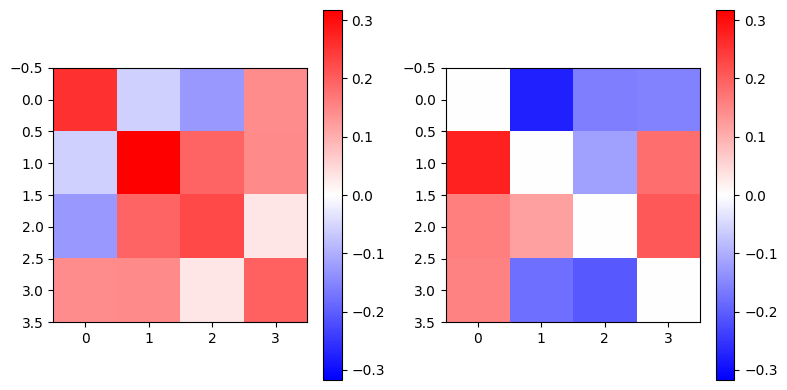

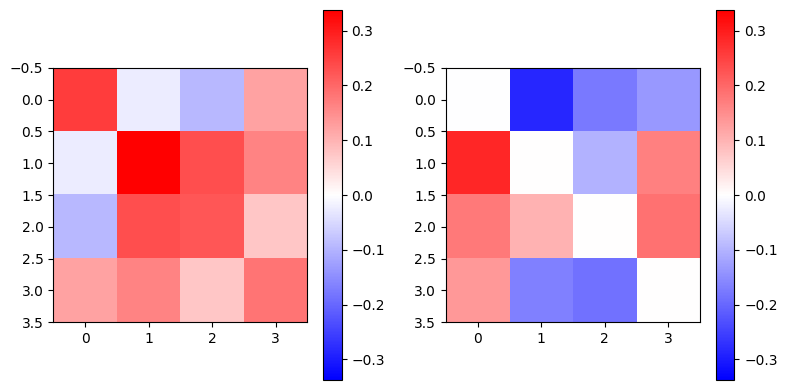

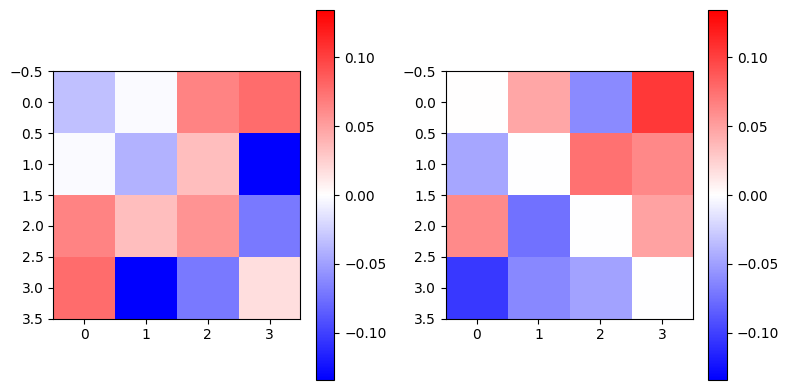

[[ 0.25723537-2.03076717e-17j -0.05735192-2.77417668e-01j
  -0.12704282-1.60953090e-01j  0.14162439-1.54630192e-01j]
 [-0.05735192+2.77417668e-01j  0.31754253+1.96392368e-18j
   0.1919514 -1.17140524e-01j  0.14488624+1.79697607e-01j]
 [-0.12704282+1.60953090e-01j  0.1919514 +1.17140524e-01j
   0.22727158-4.70121910e-19j  0.0310699 +2.06284287e-01j]
 [ 0.14162439+1.54630192e-01j  0.14488624-1.79697607e-01j
   0.0310699 -2.06284287e-01j  0.19795053+1.88138699e-17j]]
(1+0j)
0.08823279641329884
0.09144999470174342


In [35]:
path  = "Photon_REM/photonic QREM experimental data v2/benchmark QREM/*coinc.txt"
paths = glob.glob(path)
benchmark_coinc_counts = np.array([np.loadtxt(p, skiprows=2) for p in paths])
print(benchmark_coinc_counts)


# def QREM_coincidence_to_states(coincidence_counts, operator_list):
#     """
#     Takes in experimental coincidence counts and an operator order for the counts and returns the estimated state.
    
#     Steps:
#     Need to turn the coincidence counts into proper probabilities and the 
#     set of operators into a proper set of POVMs by adding a normalization operator. 
#     """
#     # Flatten standard outcome
#     coincidence_counts = coincidence_counts.flatten()


#     # Add additional operators for each projection, such that each operator becomes a POVM.
#     # The additional operators are the identity minus the operator, making each two operator identity. 
#     additional_op= np.array([np.eye(4) - op for op in operator_list])
#     # Compute the total number of coincidences for each POVM on the 4 first projections. 
#     n_partial = np.sum(coincidence_counts[:4]) 
    
#     additional_coincidenses = n_partial - coincidence_counts

#     #print(np.sum(operator_order[:4], axis = 0))
#     # Include the additional operators and coincidences in the list of operators and coincidences, making them full POVMs
#     new_op = np.append(operator_list,additional_op[4:],axis = 0)
#     new_coincidenes = np.append(coincidence_counts, additional_coincidenses[4:])
    
#     rho = photon_MLE(new_op, new_coincidenes)
    
#     return rho

# Createing the error mitigated operator list

coincidene_order_QST = ['HH', 'HV', 'VV', 'VH',
                    'RH', 'RV', 'DV', 'DH',
                    'DR', 'DD', 'RD', 'HD',
                    'VD', 'VL', 'HL', 'RL']

# First operators is perfect, second will be taken from reconstruction. 
#[[H,V],[R,L],[D,A]] 
QREM_op_dict = {
    'H': exp_povm[0].get_POVM()[0],
    'V': exp_povm[0].get_POVM()[1],
    'R': exp_povm[1].get_POVM()[0],
    'L': exp_povm[1].get_POVM()[1],
    'D': exp_povm[2].get_POVM()[0],
    'A': exp_povm[2].get_POVM()[1]	
}
print(QREM_op_dict)
coincidence_op_list = np.array([np.kron(photon_label_to_operator(name[0])[0], QREM_op_dict[name[1]]) for name in coincidene_order_QST])

print(coincidence_op_list.shape)

QREM_rho = coincidence_to_states(benchmark_coinc_counts[1], coincidence_op_list)

benchmark_rho_nolense = coincidence_to_states(benchmark_coinc_counts[0], QST_op_order)
benchmark_rho_lense = coincidence_to_states(benchmark_coinc_counts[1], QST_op_order)

vis.visualize_state(benchmark_rho_nolense)
vis.visualize_state(benchmark_rho_lense)
vis.visualize_state(QREM_rho)
vis.visualize_state(benchmark_rho_nolense - QREM_rho)

print(benchmark_rho_lense)
print(np.trace(QREM_rho))
print(sf.qubit_infidelity(benchmark_rho_nolense, benchmark_rho_lense))
print(sf.qubit_infidelity(benchmark_rho_nolense, QREM_rho))



0.5764532334912342 0.5315226350577948
0.5764532334912342 0.5026848072194574
0.5764532334912342 0.6581302139046289
0.5092861557109172 0.5315226350577947
0.5092861557109172 0.5026848072194574
0.5092861557109172 0.6581302139046288
0.381473785100936 0.5315226350577948
0.381473785100936 0.5026848072194574
0.381473785100936 0.6581302139046289


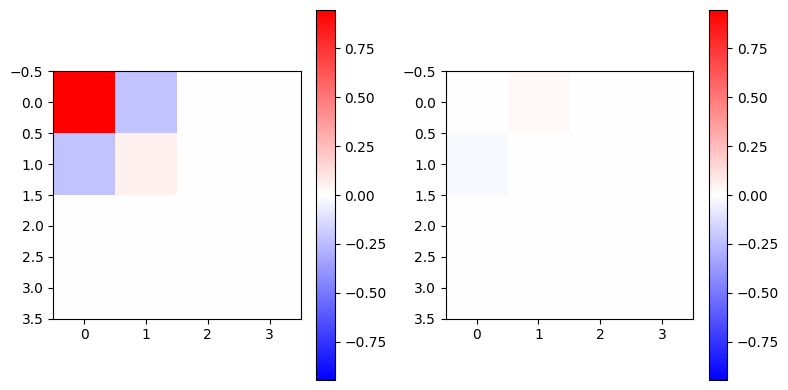

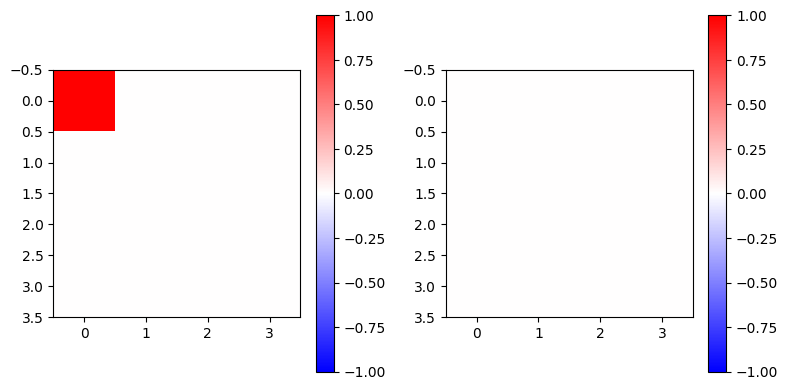

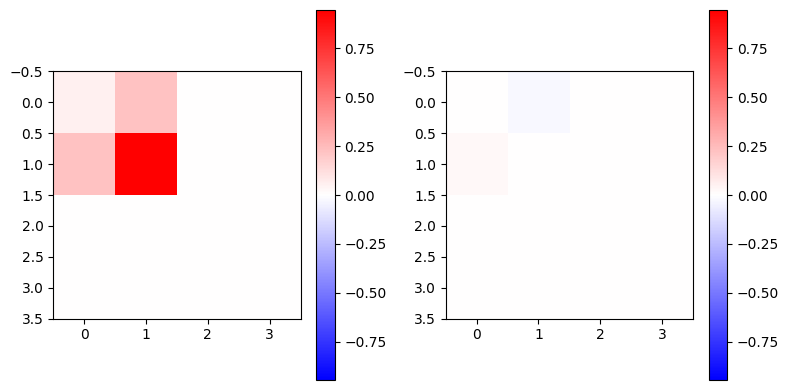

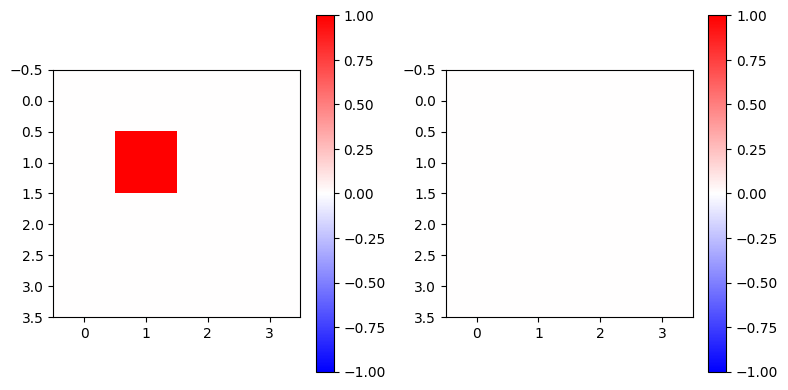

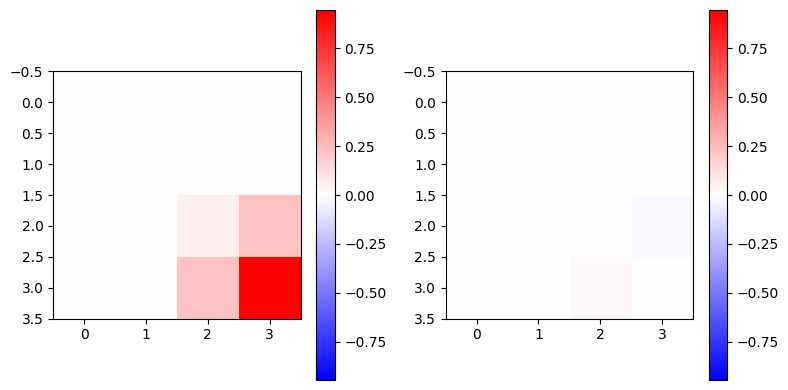

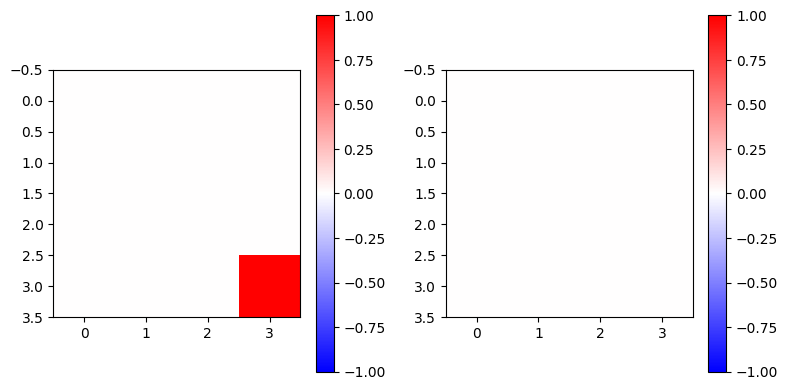

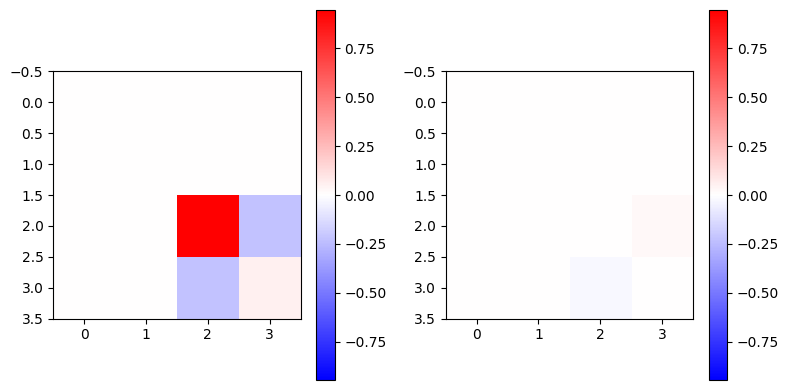

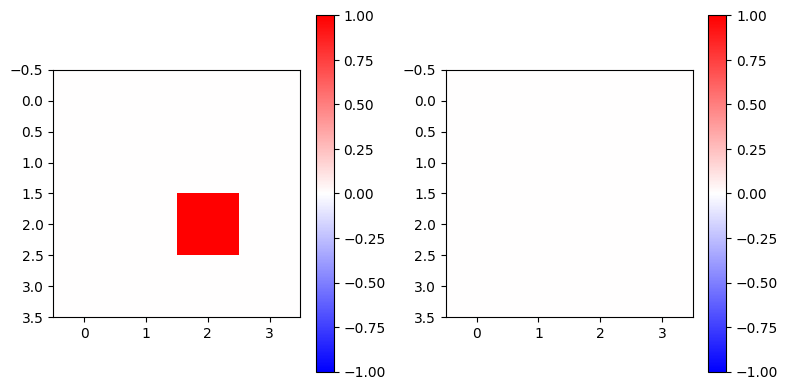

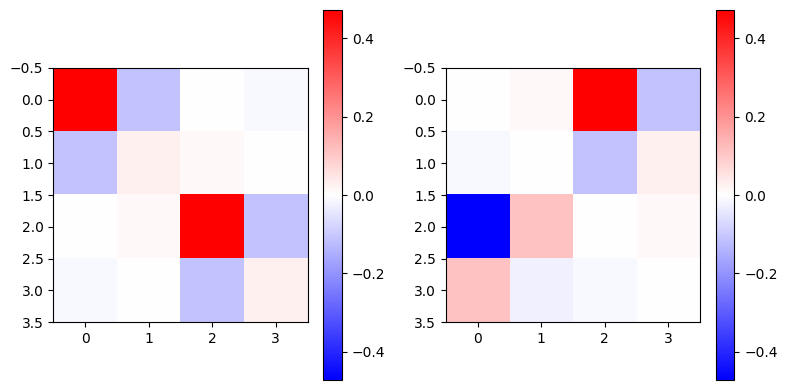

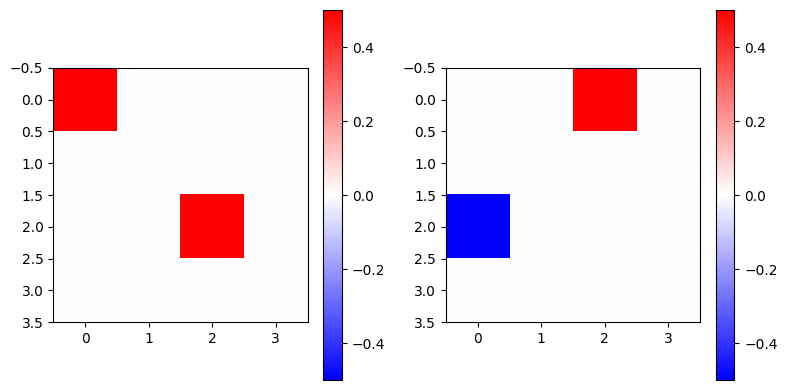

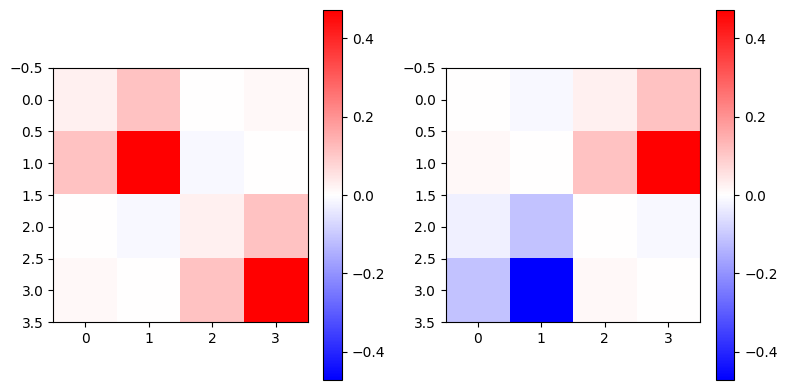

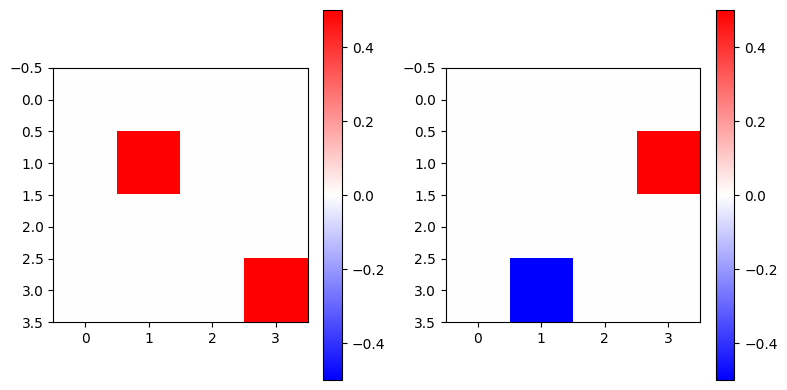

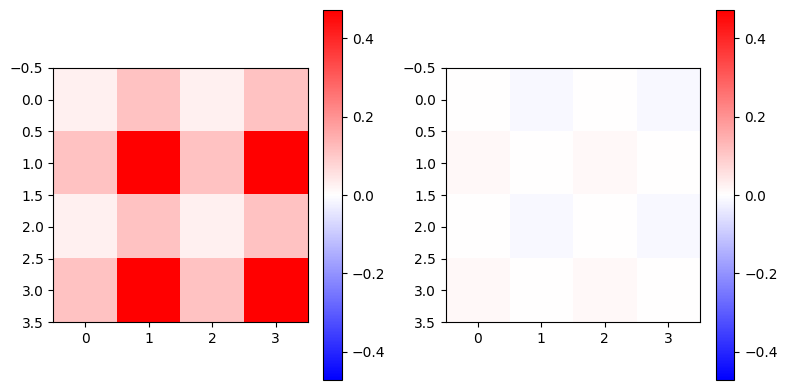

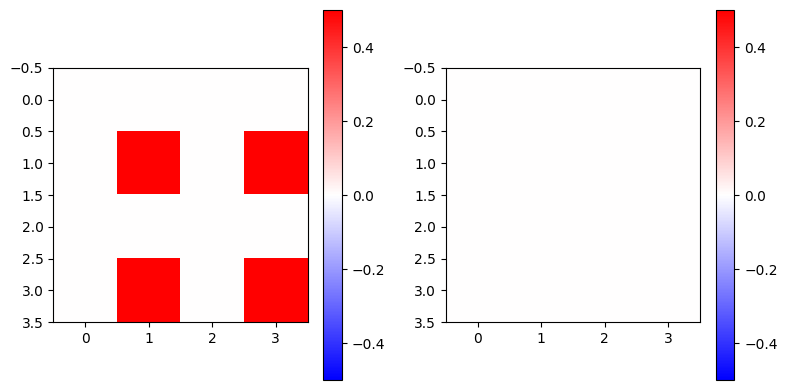

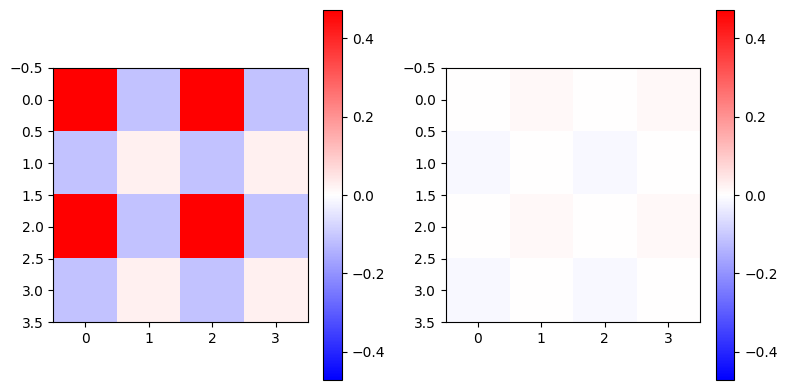

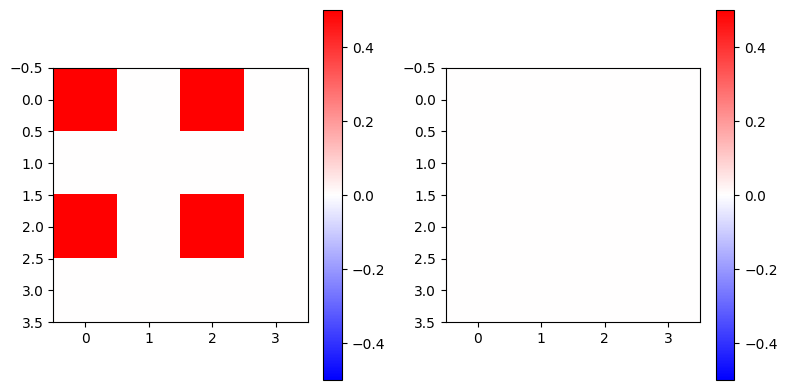

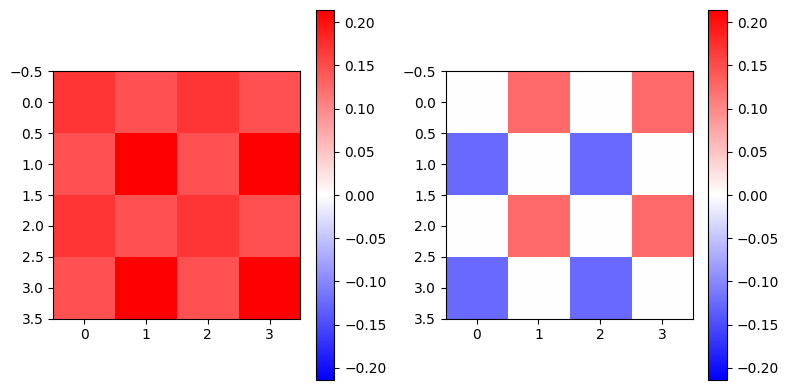

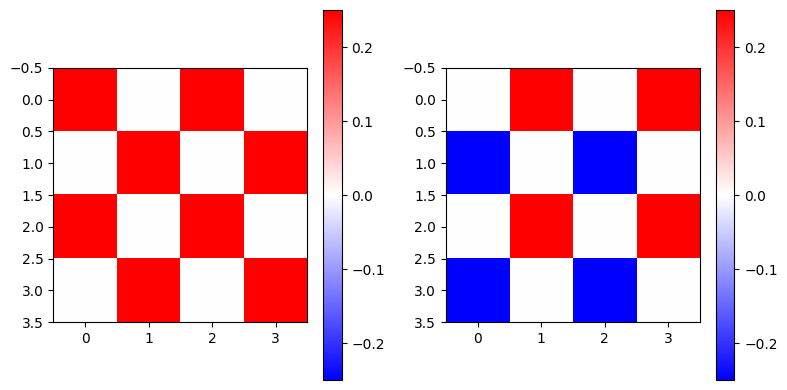

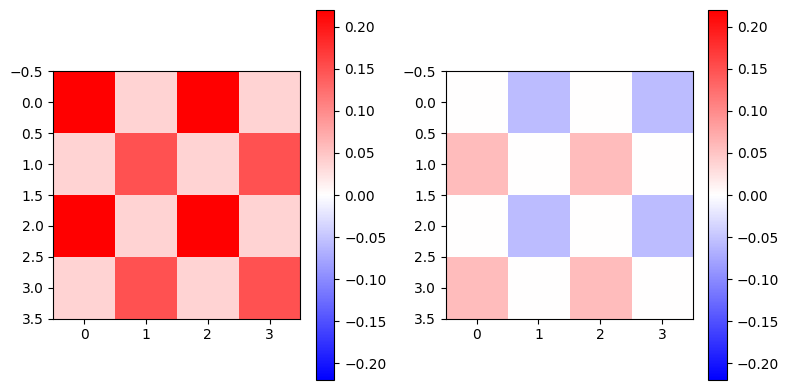

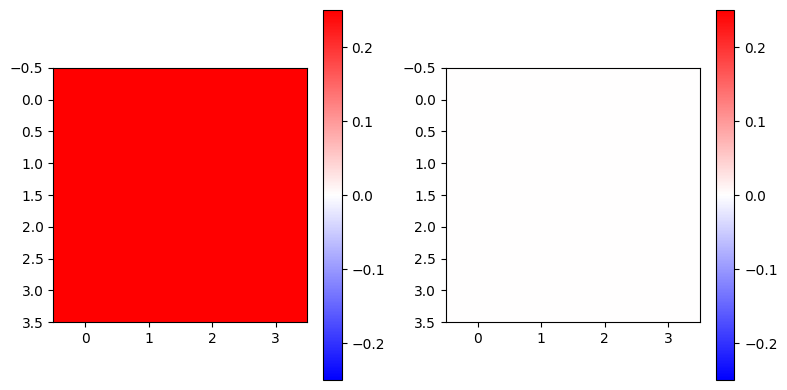

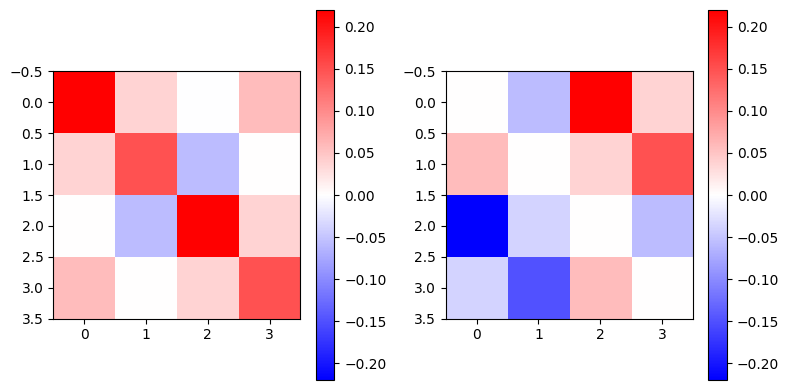

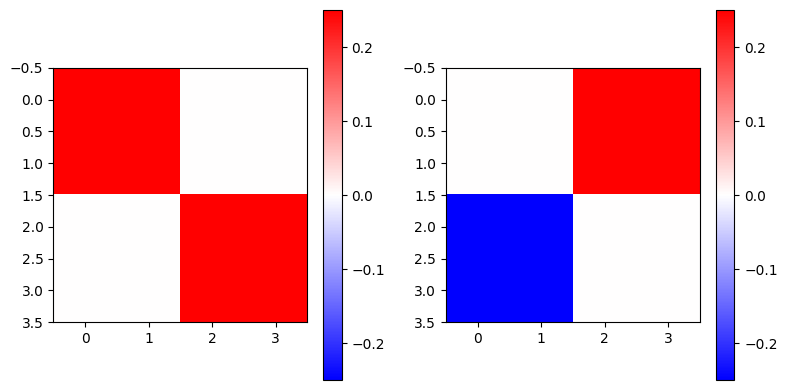

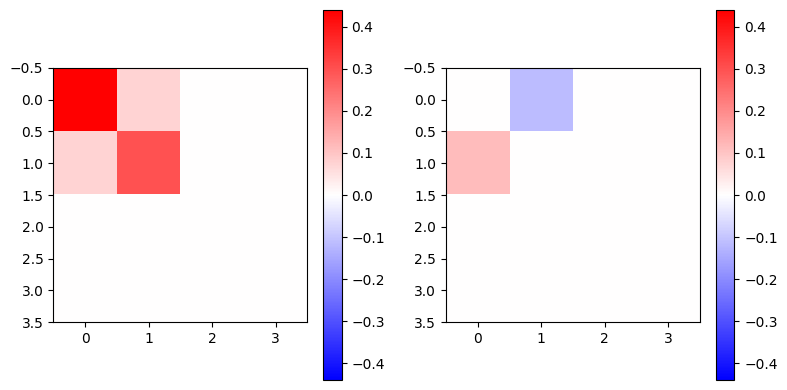

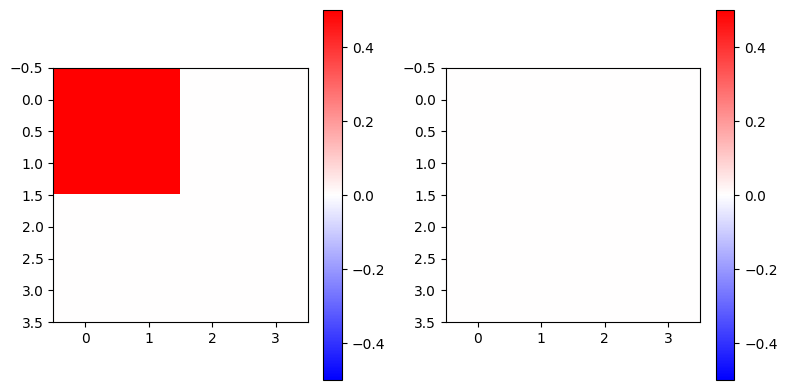

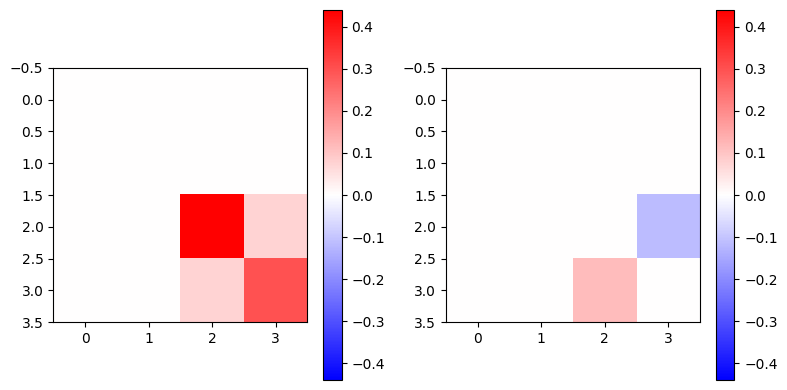

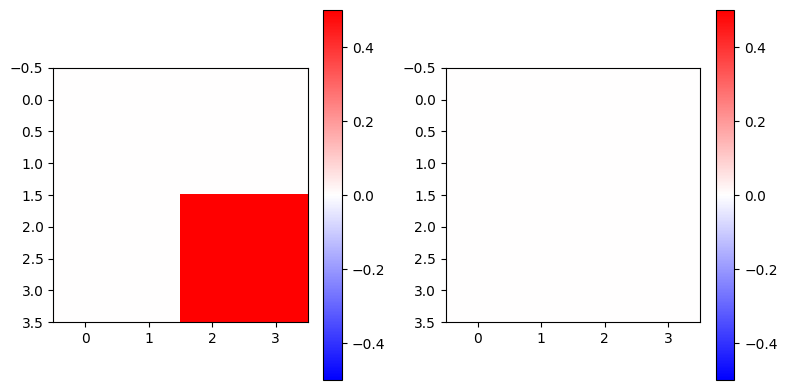

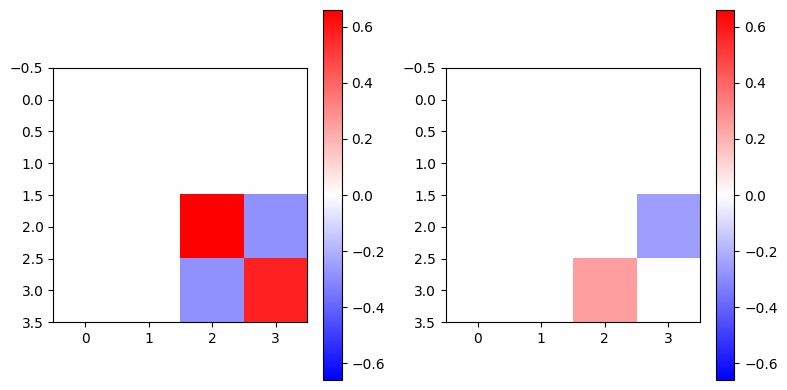

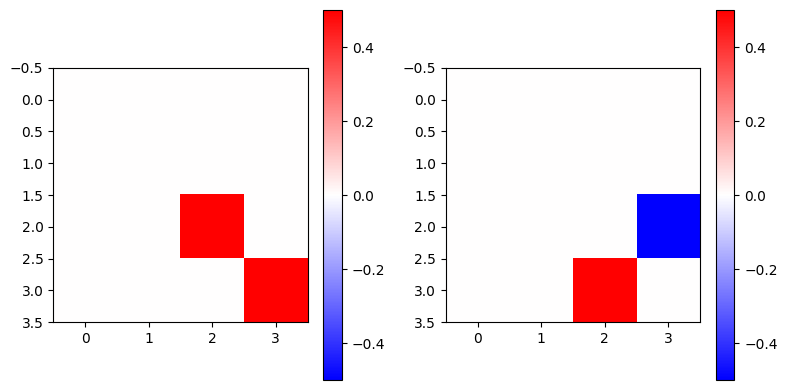

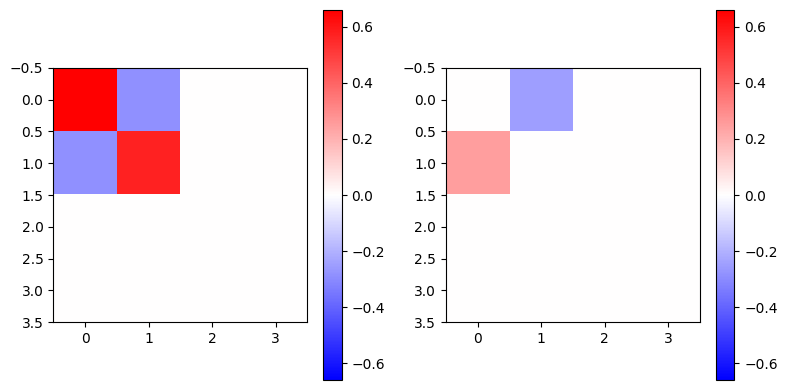

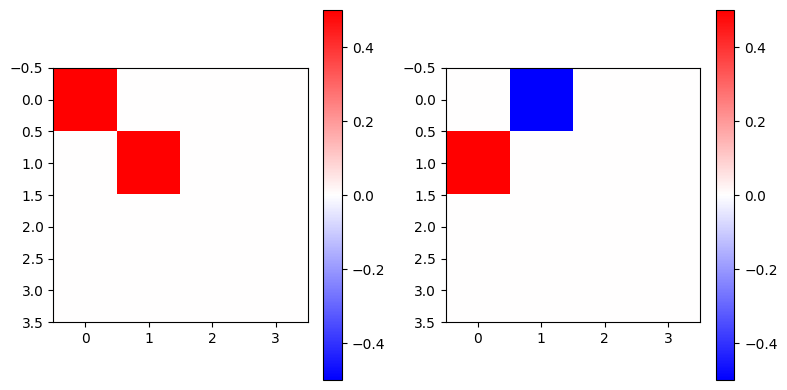

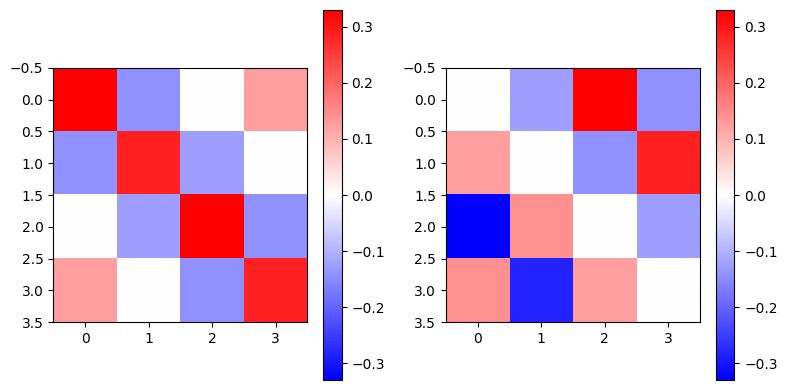

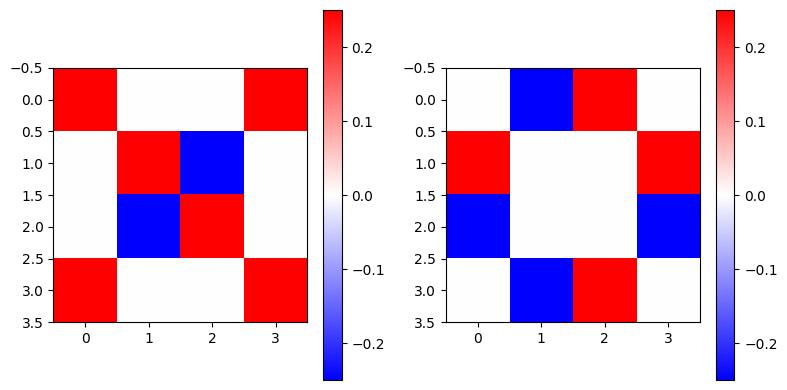

In [31]:
temp_rho = sf.generate_random_Hilbert_Schmidt_mixed_state(2)
povm = POVM.generate_Pauli_POVM(2)
for pv in povm:
    hist = pv.get_histogram(temp_rho)
    n_tot = hist[0] + hist[1]
    n_tot2 = hist[0] + hist[2]
    print(n_tot,n_tot2)

for i in range(len(coincidence_op_list)):
    vis.visualize_state(coincidence_op_list[i])
    vis.visualize_state(QST_op_order[i])